In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [18]:
data = pd.read_csv('Estimated Wave parameters_Dataset_(6.5m).csv')
data.columns

Index(['Amplitude', 'Gravity (g)', 'Average Densisty(roh)', 'Pi', 'Depth (d)',
       'Period (T)', 'Wavelength (λ)', 'Wave Speed', 'Current Speed'],
      dtype='object')

In [19]:
data = data.dropna()

In [20]:
data = data[['Amplitude', 'Gravity (g)', 'Pi', 'Depth (d)', 'Wavelength (λ)', 'Current Speed']]


In [21]:
X = data[['Amplitude', 'Gravity (g)', 'Pi', 'Depth (d)', 'Wavelength (λ)']]
y = data['Current Speed']
 


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [23]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)


In [24]:
# Define the PINN model
class CurrentSpeedPINN(nn.Module):
    def __init__(self):
        super(CurrentSpeedPINN, self).__init__()
        self.dense1 = nn.Linear(5, 32)
        self.dense2 = nn.Linear(32, 32)
        self.bn = nn.BatchNorm1d(32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, inputs):
        x = torch.relu(self.dense1(inputs))
        x = torch.relu(self.dense2(x))
        x = self.bn(x)
        output = self.output_layer(x)
        return output



In [25]:
# This section defines a custom loss function that includes both a physics-based loss 
#(enforcing a specific equation related to wave parameters and current speed) and a data loss (standard regression loss). 
#This combination allows the model to learn the underlying physics while fitting the data.

# Define the physics loss function
def physics_loss(model, X, y):
    amplitude = X[:, 0]
    gravity_g = X[:, 1]
    pi = X[:, 2]
    depth_d = X[:, 3]
    wavelength_lambda = X[:, 4]

    predictions = model(X)
    physics_equation = torch.sqrt((gravity_g * amplitude / (2 * pi)) * torch.tanh(2 * pi * depth_d / wavelength_lambda))
    physics_loss_value = torch.mean((physics_equation - predictions)**2)

    data_loss = torch.mean((y - predictions)**2)

    total_loss = physics_loss_value + data_loss

    physics_loss_gradients = torch.autograd.grad(total_loss, model.parameters(), create_graph=True)

    return physics_loss_value, data_loss, total_loss, physics_loss_gradients


In [26]:
# Initialize the model and optimizer
model = CurrentSpeedPINN()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Lists to store loss values
physics_losses = []
data_losses = []
total_losses = []

# Training loop
for epoch in range(1000):
    physics_loss_value, data_loss, total_loss, physics_loss_gradients = physics_loss(model, X_train, y_train)

    # Zero the gradients and perform backpropagation
    optimizer.zero_grad()
    total_loss.backward()

    # Update the model's weights
    optimizer.step()

    # Append loss values to the lists
    physics_losses.append(physics_loss_value.item())
    data_losses.append(data_loss.item())
    total_losses.append(total_loss.item())

    print(f"Epoch {epoch + 1}, Physics Loss: {physics_loss_value.item()}, Data Loss: {data_loss.item()}, Total Loss: {total_loss.item()}")


Epoch 1, Physics Loss: 0.3986104428768158, Data Loss: 0.14632487297058105, Total Loss: 0.5449353456497192
Epoch 2, Physics Loss: 0.25854256749153137, Data Loss: 0.02269177883863449, Total Loss: 0.28123435378074646
Epoch 3, Physics Loss: 0.23363050818443298, Data Loss: 0.01448429562151432, Total Loss: 0.24811480939388275
Epoch 4, Physics Loss: 0.22471259534358978, Data Loss: 0.022610800340771675, Total Loss: 0.2473233938217163
Epoch 5, Physics Loss: 0.2077304720878601, Data Loss: 0.022954311221837997, Total Loss: 0.2306847870349884
Epoch 6, Physics Loss: 0.18708595633506775, Data Loss: 0.019885489717125893, Total Loss: 0.2069714516401291
Epoch 7, Physics Loss: 0.1706390231847763, Data Loss: 0.021239224821329117, Total Loss: 0.19187824428081512
Epoch 8, Physics Loss: 0.15130974352359772, Data Loss: 0.019887972623109818, Total Loss: 0.17119771242141724
Epoch 9, Physics Loss: 0.13896752893924713, Data Loss: 0.025623086839914322, Total Loss: 0.16459061205387115
Epoch 10, Physics Loss: 0.126

Epoch 77, Physics Loss: 0.09095390886068344, Data Loss: 0.0481758676469326, Total Loss: 0.13912977278232574
Epoch 78, Physics Loss: 0.09062405675649643, Data Loss: 0.04850374162197113, Total Loss: 0.13912779092788696
Epoch 79, Physics Loss: 0.09030384570360184, Data Loss: 0.04882257059216499, Total Loss: 0.13912642002105713
Epoch 80, Physics Loss: 0.09000515192747116, Data Loss: 0.04911958798766136, Total Loss: 0.13912473618984222
Epoch 81, Physics Loss: 0.0897403359413147, Data Loss: 0.049383215606212616, Total Loss: 0.1391235589981079
Epoch 82, Physics Loss: 0.08951885253190994, Data Loss: 0.049605198204517365, Total Loss: 0.1391240507364273
Epoch 83, Physics Loss: 0.08934881538152695, Data Loss: 0.04977757856249809, Total Loss: 0.13912639021873474
Epoch 84, Physics Loss: 0.08923186361789703, Data Loss: 0.04989756643772125, Total Loss: 0.1391294300556183
Epoch 85, Physics Loss: 0.08917129784822464, Data Loss: 0.049960214644670486, Total Loss: 0.13913151621818542
Epoch 86, Physics Los

Epoch 152, Physics Loss: 0.0901901125907898, Data Loss: 0.04892096295952797, Total Loss: 0.13911107182502747
Epoch 153, Physics Loss: 0.09018982946872711, Data Loss: 0.04892122000455856, Total Loss: 0.13911104202270508
Epoch 154, Physics Loss: 0.09018677473068237, Data Loss: 0.04892423003911972, Total Loss: 0.1391110122203827
Epoch 155, Physics Loss: 0.09018263965845108, Data Loss: 0.04892835021018982, Total Loss: 0.1391109824180603
Epoch 156, Physics Loss: 0.09017826616764069, Data Loss: 0.04893268644809723, Total Loss: 0.13911095261573792
Epoch 157, Physics Loss: 0.09017196297645569, Data Loss: 0.04893895983695984, Total Loss: 0.13911092281341553
Epoch 158, Physics Loss: 0.09016547352075577, Data Loss: 0.04894541949033737, Total Loss: 0.13911089301109314
Epoch 159, Physics Loss: 0.0901588425040245, Data Loss: 0.04895200580358505, Total Loss: 0.13911084830760956
Epoch 160, Physics Loss: 0.09015373140573502, Data Loss: 0.04895710572600365, Total Loss: 0.13911083340644836
Epoch 161, Phy

Epoch 228, Physics Loss: 0.09015686064958572, Data Loss: 0.04895295575261116, Total Loss: 0.13910982012748718
Epoch 229, Physics Loss: 0.09015772491693497, Data Loss: 0.048952069133520126, Total Loss: 0.1391097903251648
Epoch 230, Physics Loss: 0.09015683084726334, Data Loss: 0.048952966928482056, Total Loss: 0.1391097903251648
Epoch 231, Physics Loss: 0.09015743434429169, Data Loss: 0.04895234853029251, Total Loss: 0.1391097903251648
Epoch 232, Physics Loss: 0.09015651047229767, Data Loss: 0.048953279852867126, Total Loss: 0.1391097903251648
Epoch 233, Physics Loss: 0.09015776962041855, Data Loss: 0.04895199462771416, Total Loss: 0.1391097605228424
Epoch 234, Physics Loss: 0.09015581011772156, Data Loss: 0.04895394295454025, Total Loss: 0.1391097605228424
Epoch 235, Physics Loss: 0.09015637636184692, Data Loss: 0.04895338416099548, Total Loss: 0.1391097605228424
Epoch 236, Physics Loss: 0.09015587717294693, Data Loss: 0.04895386844873428, Total Loss: 0.1391097456216812
Epoch 237, Phys

Epoch 303, Physics Loss: 0.09015580266714096, Data Loss: 0.048953622579574585, Total Loss: 0.13910943269729614
Epoch 304, Physics Loss: 0.0901574119925499, Data Loss: 0.048951998353004456, Total Loss: 0.13910940289497375
Epoch 305, Physics Loss: 0.09015709161758423, Data Loss: 0.04895232617855072, Total Loss: 0.13910941779613495
Epoch 306, Physics Loss: 0.09015631675720215, Data Loss: 0.0489530935883522, Total Loss: 0.13910940289497375
Epoch 307, Physics Loss: 0.09015662968158722, Data Loss: 0.048952776938676834, Total Loss: 0.13910940289497375
Epoch 308, Physics Loss: 0.09015683084726334, Data Loss: 0.04895256832242012, Total Loss: 0.13910940289497375
Epoch 309, Physics Loss: 0.09015723317861557, Data Loss: 0.048952169716358185, Total Loss: 0.13910940289497375
Epoch 310, Physics Loss: 0.09015576541423798, Data Loss: 0.048953648656606674, Total Loss: 0.13910941779613495
Epoch 311, Physics Loss: 0.09015628695487976, Data Loss: 0.0489531047642231, Total Loss: 0.13910938799381256
Epoch 31

Epoch 379, Physics Loss: 0.09015811234712601, Data Loss: 0.048951148986816406, Total Loss: 0.13910925388336182
Epoch 380, Physics Loss: 0.09015700966119766, Data Loss: 0.04895223304629326, Total Loss: 0.13910923898220062
Epoch 381, Physics Loss: 0.09015651047229767, Data Loss: 0.04895273968577385, Total Loss: 0.13910925388336182
Epoch 382, Physics Loss: 0.09015637636184692, Data Loss: 0.04895287752151489, Total Loss: 0.13910925388336182
Epoch 383, Physics Loss: 0.09015674889087677, Data Loss: 0.04895249381661415, Total Loss: 0.13910923898220062
Epoch 384, Physics Loss: 0.09015750885009766, Data Loss: 0.04895174875855446, Total Loss: 0.13910925388336182
Epoch 385, Physics Loss: 0.09015649557113647, Data Loss: 0.04895276203751564, Total Loss: 0.13910925388336182
Epoch 386, Physics Loss: 0.0901557207107544, Data Loss: 0.04895352944731712, Total Loss: 0.13910925388336182
Epoch 387, Physics Loss: 0.09015648812055588, Data Loss: 0.04895276948809624, Total Loss: 0.13910925388336182
Epoch 388,

Epoch 455, Physics Loss: 0.09015794843435287, Data Loss: 0.04895123466849327, Total Loss: 0.13910917937755585
Epoch 456, Physics Loss: 0.09015713632106781, Data Loss: 0.04895205423235893, Total Loss: 0.13910919427871704
Epoch 457, Physics Loss: 0.09015700221061707, Data Loss: 0.04895218089222908, Total Loss: 0.13910917937755585
Epoch 458, Physics Loss: 0.09015671163797379, Data Loss: 0.04895247519016266, Total Loss: 0.13910919427871704
Epoch 459, Physics Loss: 0.09015639871358871, Data Loss: 0.04895279183983803, Total Loss: 0.13910919427871704
Epoch 460, Physics Loss: 0.09015600383281708, Data Loss: 0.04895317927002907, Total Loss: 0.13910917937755585
Epoch 461, Physics Loss: 0.0901569351553917, Data Loss: 0.04895225539803505, Total Loss: 0.13910919427871704
Epoch 462, Physics Loss: 0.09015758335590363, Data Loss: 0.04895160719752312, Total Loss: 0.13910919427871704
Epoch 463, Physics Loss: 0.09015815705060959, Data Loss: 0.04895101115107536, Total Loss: 0.13910916447639465
Epoch 464, 

Epoch 530, Physics Loss: 0.09015606343746185, Data Loss: 0.048953086137771606, Total Loss: 0.13910914957523346
Epoch 531, Physics Loss: 0.09015563875436783, Data Loss: 0.04895351082086563, Total Loss: 0.13910914957523346
Epoch 532, Physics Loss: 0.09015639871358871, Data Loss: 0.04895275458693504, Total Loss: 0.13910914957523346
Epoch 533, Physics Loss: 0.09015732258558273, Data Loss: 0.048951826989650726, Total Loss: 0.13910914957523346
Epoch 534, Physics Loss: 0.09015762805938721, Data Loss: 0.048951517790555954, Total Loss: 0.13910914957523346
Epoch 535, Physics Loss: 0.09015768021345139, Data Loss: 0.04895148053765297, Total Loss: 0.13910916447639465
Epoch 536, Physics Loss: 0.09015730768442154, Data Loss: 0.048951853066682816, Total Loss: 0.13910916447639465
Epoch 537, Physics Loss: 0.09015768766403198, Data Loss: 0.048951465636491776, Total Loss: 0.13910914957523346
Epoch 538, Physics Loss: 0.09015730768442154, Data Loss: 0.04895184934139252, Total Loss: 0.13910916447639465
Epoch

Epoch 606, Physics Loss: 0.09015736728906631, Data Loss: 0.048951778560876846, Total Loss: 0.13910914957523346
Epoch 607, Physics Loss: 0.09015798568725586, Data Loss: 0.04895114526152611, Total Loss: 0.13910913467407227
Epoch 608, Physics Loss: 0.09015792608261108, Data Loss: 0.04895120859146118, Total Loss: 0.13910913467407227
Epoch 609, Physics Loss: 0.09015843272209167, Data Loss: 0.04895070567727089, Total Loss: 0.13910913467407227
Epoch 610, Physics Loss: 0.09015835076570511, Data Loss: 0.048950791358947754, Total Loss: 0.13910913467407227
Epoch 611, Physics Loss: 0.09015745669603348, Data Loss: 0.048951681703329086, Total Loss: 0.13910913467407227
Epoch 612, Physics Loss: 0.09015730768442154, Data Loss: 0.048951826989650726, Total Loss: 0.13910913467407227
Epoch 613, Physics Loss: 0.09015582501888275, Data Loss: 0.048953309655189514, Total Loss: 0.13910913467407227
Epoch 614, Physics Loss: 0.09015513956546783, Data Loss: 0.04895399510860443, Total Loss: 0.13910913467407227
Epoch

Epoch 682, Physics Loss: 0.09015683084726334, Data Loss: 0.048952292650938034, Total Loss: 0.13910911977291107
Epoch 683, Physics Loss: 0.09015671908855438, Data Loss: 0.048952411860227585, Total Loss: 0.13910913467407227
Epoch 684, Physics Loss: 0.09015671908855438, Data Loss: 0.04895239695906639, Total Loss: 0.13910911977291107
Epoch 685, Physics Loss: 0.090157151222229, Data Loss: 0.048951976001262665, Total Loss: 0.13910913467407227
Epoch 686, Physics Loss: 0.09015672653913498, Data Loss: 0.04895239323377609, Total Loss: 0.13910911977291107
Epoch 687, Physics Loss: 0.09015775471925735, Data Loss: 0.04895136132836342, Total Loss: 0.13910911977291107
Epoch 688, Physics Loss: 0.0901578813791275, Data Loss: 0.048951245844364166, Total Loss: 0.13910913467407227
Epoch 689, Physics Loss: 0.09015844017267227, Data Loss: 0.0489506796002388, Total Loss: 0.13910911977291107
Epoch 690, Physics Loss: 0.09015745669603348, Data Loss: 0.04895167425274849, Total Loss: 0.13910913467407227
Epoch 691,

Epoch 758, Physics Loss: 0.0901564285159111, Data Loss: 0.04895270615816116, Total Loss: 0.13910913467407227
Epoch 759, Physics Loss: 0.0901569128036499, Data Loss: 0.04895222187042236, Total Loss: 0.13910913467407227
Epoch 760, Physics Loss: 0.09015685319900513, Data Loss: 0.04895228147506714, Total Loss: 0.13910913467407227
Epoch 761, Physics Loss: 0.09015702456235886, Data Loss: 0.04895210638642311, Total Loss: 0.13910913467407227
Epoch 762, Physics Loss: 0.0901576578617096, Data Loss: 0.048951465636491776, Total Loss: 0.13910911977291107
Epoch 763, Physics Loss: 0.09015686810016632, Data Loss: 0.04895225539803505, Total Loss: 0.13910911977291107
Epoch 764, Physics Loss: 0.09015613794326782, Data Loss: 0.04895298182964325, Total Loss: 0.13910911977291107
Epoch 765, Physics Loss: 0.09015659242868423, Data Loss: 0.048952534794807434, Total Loss: 0.13910913467407227
Epoch 766, Physics Loss: 0.09015686810016632, Data Loss: 0.04895224794745445, Total Loss: 0.13910911977291107
Epoch 767, 

Epoch 834, Physics Loss: 0.09015720337629318, Data Loss: 0.04895192012190819, Total Loss: 0.13910911977291107
Epoch 835, Physics Loss: 0.09015688300132751, Data Loss: 0.04895223677158356, Total Loss: 0.13910911977291107
Epoch 836, Physics Loss: 0.09015652537345886, Data Loss: 0.04895259439945221, Total Loss: 0.13910911977291107
Epoch 837, Physics Loss: 0.09015648812055588, Data Loss: 0.04895263910293579, Total Loss: 0.13910913467407227
Epoch 838, Physics Loss: 0.09015657752752304, Data Loss: 0.04895254969596863, Total Loss: 0.13910913467407227
Epoch 839, Physics Loss: 0.09015738219022751, Data Loss: 0.04895174130797386, Total Loss: 0.13910911977291107
Epoch 840, Physics Loss: 0.09015613794326782, Data Loss: 0.048952993005514145, Total Loss: 0.13910913467407227
Epoch 841, Physics Loss: 0.09015543758869171, Data Loss: 0.048953671008348465, Total Loss: 0.13910910487174988
Epoch 842, Physics Loss: 0.09015554189682007, Data Loss: 0.04895356670022011, Total Loss: 0.13910910487174988
Epoch 84

Epoch 910, Physics Loss: 0.09015663713216782, Data Loss: 0.048952482640743256, Total Loss: 0.13910911977291107
Epoch 911, Physics Loss: 0.09015625715255737, Data Loss: 0.0489528626203537, Total Loss: 0.13910911977291107
Epoch 912, Physics Loss: 0.09015657752752304, Data Loss: 0.04895254224538803, Total Loss: 0.13910911977291107
Epoch 913, Physics Loss: 0.09015586227178574, Data Loss: 0.048953257501125336, Total Loss: 0.13910911977291107
Epoch 914, Physics Loss: 0.09015597403049469, Data Loss: 0.04895314946770668, Total Loss: 0.13910911977291107
Epoch 915, Physics Loss: 0.09015657007694244, Data Loss: 0.048952553421258926, Total Loss: 0.13910911977291107
Epoch 916, Physics Loss: 0.09015791863203049, Data Loss: 0.04895120486617088, Total Loss: 0.13910911977291107
Epoch 917, Physics Loss: 0.09015777707099915, Data Loss: 0.04895133897662163, Total Loss: 0.13910911977291107
Epoch 918, Physics Loss: 0.09015754610300064, Data Loss: 0.04895158112049103, Total Loss: 0.13910913467407227
Epoch 91

Epoch 986, Physics Loss: 0.09015805274248123, Data Loss: 0.048951081931591034, Total Loss: 0.13910913467407227
Epoch 987, Physics Loss: 0.09015868604183197, Data Loss: 0.048950448632240295, Total Loss: 0.13910913467407227
Epoch 988, Physics Loss: 0.09015797078609467, Data Loss: 0.0489511638879776, Total Loss: 0.13910913467407227
Epoch 989, Physics Loss: 0.09015662223100662, Data Loss: 0.04895249754190445, Total Loss: 0.13910911977291107
Epoch 990, Physics Loss: 0.09015603363513947, Data Loss: 0.04895307868719101, Total Loss: 0.13910910487174988
Epoch 991, Physics Loss: 0.09015540778636932, Data Loss: 0.04895371198654175, Total Loss: 0.13910911977291107
Epoch 992, Physics Loss: 0.09015485644340515, Data Loss: 0.04895425960421562, Total Loss: 0.13910911977291107
Epoch 993, Physics Loss: 0.09015465527772903, Data Loss: 0.04895445704460144, Total Loss: 0.13910910487174988
Epoch 994, Physics Loss: 0.09015503525733948, Data Loss: 0.048954084515571594, Total Loss: 0.13910911977291107
Epoch 99

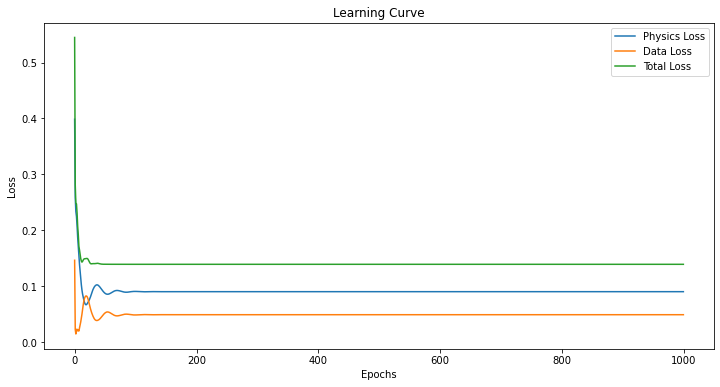

In [27]:
# Plot the learning curve
plt.figure(figsize=(12, 6))
plt.plot(physics_losses, label='Physics Loss')
plt.plot(data_losses, label='Data Loss')
plt.plot(total_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()

In [28]:
# Make predictions on the training data
with torch.no_grad():
    y_train_pred = model(X_train)

MSE = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_train.numpy(), y_train_pred.numpy())

print(f"Training Mean Squared Error: {MSE}")
print(f"Training Root Mean Squared Error: {RMSE}")
print(f"Training Mean Absolute Error: {MAE}")

Training Mean Squared Error: 0.04895048215985298
Training Root Mean Squared Error: 0.22124755382537842
Training Mean Absolute Error: 0.2069903314113617


In [29]:
# Evaluate the model on test data
with torch.no_grad():
    y_pred = model(X_test)

MSE = mean_squared_error(y_test.numpy(), y_pred.numpy())
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_test.numpy(), y_pred.numpy())

print(f"Test Mean Squared Error: {MSE}")
print(f"Test Root Mean Squared Error: {RMSE}")
print(f"Test Mean Absolute Error: {MAE}")


Test Mean Squared Error: 0.05122549459338188
Test Root Mean Squared Error: 0.22633050382137299
Test Mean Absolute Error: 0.21046102046966553
